In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import numpy.linalg as lg
from numpy import (linspace, sin, cos, pi)
from numpy.fft import rfft, rfftfreq

# Q - предполагаемая ошибка в центре этого раунда
Q = 0.3
# R - погрешность измерения следующего раунда
R = 0.3
# Accumulated_Error - это оценочная ошибка предыдущего раунда, которая представляется как накопление всех ошибок.
Accumulated_Error = 1
# Начальное старое значение
kalman_adc_old = 0

SCOPE = 50

In [2]:
len_m = 1500
x = linspace(0, len_m, len_m)  # возвращает равномерно распределённые числа в данном интервале

left_ind = math.floor(len_m * 0.165)
right_ind = math.ceil(len_m * 0.185)

mu, sigma = 0, 1
a0 = 1
a1 = 0.8
a2 = 0.5
w0 = 0.1815
w1 = 0.1781
w2 = 0.015
k = 0.0000005
noise_mas = linspace(0.1, 0.5, 11)


In [3]:
def kalman(ADC_Value):
    global kalman_adc_old
    global Accumulated_Error

    # Отслеживать, когда новое значение слишком отличается от старого значения
    if (abs(ADC_Value-kalman_adc_old)/SCOPE > 0.25):
        Old_Input = ADC_Value*0.382 + kalman_adc_old*0.618
    else:
        Old_Input = kalman_adc_old

    # Общая ошибка предыдущего раунда = накопленная ошибка ^ 2 + оценочная ошибка ^ 2
    Old_Error_All = (Accumulated_Error**2 + Q**2)**(1/2)

    # R - расчетная ошибка этого раунда
    # H - доверие обеих сторон, рассчитанное с использованием среднеквадратичной ошибки
    H = Old_Error_All**2/(Old_Error_All**2 + R**2)

    # Старое значение + 1.00001 / (1.00001 + 0.1) * (новое значение - старое значение)
    kalman_adc = Old_Input + H * (ADC_Value - Old_Input)

    # Рассчитать новую накопленную ошибку
    Accumulated_Error = ((1 - H)*Old_Error_All**2)**(1/2)
    # Новое значение становится старым значением
    kalman_adc_old = kalman_adc
    return kalman_adc

In [4]:
def Kalman(sig):
    """"   """
    adc=[]
    for i in range(len(sig)):
        adc.append(kalman(sig[i]))
    
    return(adc)

In [5]:
def Generator(n_a):
    """   """
    f1 = np.exp(-k*x**2)*((a0 + 0.1*(np.random.normal(mu, sigma, len_m)))*sin(2 * pi * w0 * x + 2 * pi * 0.00) + (a1 + 0.1*(np.random.normal(mu, sigma, len_m)))*sin(2 * pi * w1 * x + 2 * pi * 0.00) + (a2 + 0.2*(np.random.normal(mu, sigma, len_m)))*sin(2 * pi * w2 * x + 2 * pi * 0.00)) + [x for x in (n_a + 0.15)*(np.random.normal(mu, sigma, len_m))]
    f2 = np.exp(-k*x**2)*((a0 + 0.05*(np.random.normal(mu, sigma, len_m)))*sin(2 * pi * w0 * x + 2 * pi * 0.00425) + (a1 + 0.05*(np.random.normal(mu, sigma, len_m)))*sin(2 * pi * w1 * x + 2 * pi * 0.00425) + (a2 + 0.1*(np.random.normal(mu, sigma, len_m)))*sin(2 * pi * w2 * x + 2 * pi * 0.025)) + [x for x in (n_a + 0.2)*(np.random.normal(mu, sigma, len_m))]
    f3 = np.exp(-k*x**2)*((a0 + 0.09*(np.random.normal(mu, sigma, len_m)))*sin(2 * pi * w0 * x + 2 * pi * 0.0085) + (a1 + 0.09*(np.random.normal(mu, sigma, len_m)))*sin(2 * pi * w1 * x + 2 * pi * 0.0085) + (a2 + 0.18*(np.random.normal(mu, sigma, len_m)))*sin(2 * pi * w2 * x + 2 * pi * 0.0085)) + [x for x in (n_a + 0.1)*(np.random.normal(mu, sigma, len_m))]
    f4 = np.exp(-k*x**2)*((a0 + 0.11*(np.random.normal(mu, sigma, len_m)))*sin(2 * pi * w0 * x + 2 * pi * 0.01275) + (a1 + 0.11*(np.random.normal(mu, sigma, len_m)))*sin(2 * pi * w1 * x + 2 * pi * 0.01275) + (a2 + 0.22*(np.random.normal(mu, sigma, len_m)))*sin(2 * pi * w2 * x + 2 * pi * 0.01275)) + [x for x in n_a*(np.random.normal(mu, sigma, len_m))]

    f1 = Kalman(f1)
    f2 = Kalman(f2)
    f3 = Kalman(f3)
    f4 = Kalman(f4)
    
    Mass = np.c_[f1, f2, f3, f4]
    Mass2 = np.delete(Mass, (0), axis=0)
    zeros = np.array([0, 0, 0, 0])
    Mass2 = np.vstack((Mass2, zeros))
    Mass = np.concatenate((Mass, Mass2), axis=1)

    Mass2 = np.delete(Mass, (0, 1), axis=0) 
    zeros_2 = np.zeros((2, 8))
    Mass2 = np.vstack((Mass2, zeros_2))
    Mass = np.concatenate((Mass, Mass2), axis=1)
    
    return(Mass)

In [6]:
def SVD(data):
    """   """
    U, sng, Mass_SVD = lg.svd(data.T, full_matrices=False)
    nu_fft = rfftfreq(len_m, 1.)
    
    return(nu_fft, Mass_SVD)

In [7]:
def FFT(svd, nu):
    """   """
    nu_mas = np.zeros((16,1))
    
    for i in range(svd.shape[0]):
        spectrf = rfft(svd[i, :])
        #nu[np.argmax(np.abs(spectrf), axis=0)]
        
        tmp_nu = nu[left_ind: right_ind]
        print
        tmp_x = spectrf[left_ind: right_ind]

        ind = np.argmax(tmp_x)
        frq_founded = tmp_nu[ind]
        nu_mas[i] = frq_founded
        
        
    delta = nu_mas - w1
    #print(delta)
    real_delta = min(np.abs(delta))
    return(real_delta)

In [8]:
def Plotter(noise_mass):
    """   """
    points_delta = np.zeros((11,1))
    for i in range(noise_mass.shape[0]):
        Mas = Generator(noise_mass[i])
        nu_fft, Mas_SVD = SVD(Mas)
        points_delta[i] = FFT(Mas_SVD, nu_fft)
        
    figsize = [10, 7]
    plt.figure(figsize=figsize)
    plt.plot(noise_mass, np.abs(points_delta), 'o', c='r', linestyle='solid')
    plt.xlabel("Noise level", fontsize=15)
    plt.ylabel("Error", fontsize=15)
    plt.grid(True)
    #plt.title("Sports Watch Data")
    
    plt.savefig('Kalman_Noise.png')
    plt.show()   

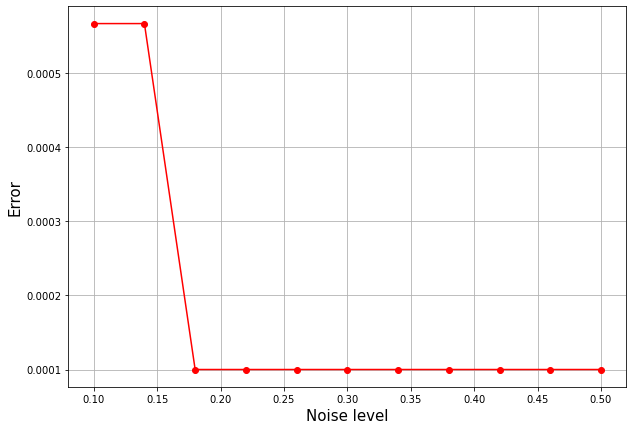

In [9]:
Plotter(noise_mas)